In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import ranksums
import os
%matplotlib inline

In [2]:
var_to_plot = "median"
palette="colorblind"

file_suffix = "_cd1_nb1"

parameter_name_map = {"alpha" : "concentration", 
                      "context_similarity_depth_1" : "context weight level 1",
                      "context_similarity_depth_2" : "context weight level 2", 
                      "repeat_bias_1_back" : "repeat bias",
                      "timeconstant_within_session_A" : "time constant"}
sim_name_map = {0 : "OLD: sim 1",
                1 : "OLD: sim 2",
                2 : "sim 1b",
                3 : "sim 2b",
                4 : "OLD pop. sim 1",
                5 : "OLD pop. sim 2",
                6 : "pop. sim 1b",
                7 : "pop. sim 2b",
                8 : "sim. 1",
                9 : "sim. 2",
                10: "pop. sim. 1",
                11: "pop. sim. 2",
                12 : "sim. 3",
                13 : "sim. 4",}

def load_summary(sim, block):
    df_a  = pd.DataFrame()
    df2_a = pd.DataFrame()

    if(isinstance(sim,int)):
        sim = [sim]
    if(isinstance(block,int)):
        block = [block]

    for sim_c in sim:
        for block_c in block:
            #print(f"sim {sim_c}, block {block_c}")
            # df = pd.read_pickle(f"Results/Simulations/sim_summary_{sim_c}_block_{block_c}.pkl")
            df = pd.read_pickle(f"Results/Simulations/sim_summary_{sim_c}_block_{block_c}{file_suffix}.pkl")
            df.index.name = "parameter"
            df = df.reset_index()
            df["simulation"] = sim_c
            df["parameter"] = df["parameter"].map(parameter_name_map)
            df["simulation"] = df["simulation"].map(sim_name_map)
            df2 = df.pivot(index=["simulation","block","run"],columns=["parameter"], values=[var_to_plot]).droplevel(0,axis=1)

            df_a  = pd.concat([df_a, df])
            df2_a = pd.concat([df2_a,df2])
    ms = df2_a.reset_index().groupby(["simulation","block"]).mean()
    return df_a, df2_a, ms

def load_samples(sim, block):
    df = pd.read_pickle(f"Results/Simulations/sim_{sim}_block_{block}{file_suffix}.pkl")
    df.rename(columns=parameter_name_map, inplace=True)
    df["simulation"] = df["simulation"].map(sim_name_map)
    return df


In [3]:
def test_posterior_marginals_separation(sims, block):
    assert len(sims) == 2, "must have two sims"
    if(isinstance(block,int)):
        block = [block]

    a,*_ = load_summary(sims[0], block[0])
    params = list(a["parameter"].unique());
    fields = params + ["simulation","run" ]
    aurocs = None
    for bb,block_c in enumerate(block):
        df1 = load_samples(sims[0], block_c)[fields]
        df2 = load_samples(sims[1], block_c)[fields]

        grouped1 = df1.groupby("run")
        grouped2 = df2.groupby("run")
        print(f"block {bb}")

        if(aurocs is None):
            aurocs = np.zeros((len(params), len(block), len(grouped1), len(grouped2) ))

        for r1, g1 in grouped1:
            if(r1 % 10 == 0):
                print(f"  run {r1}")
            for r2, g2 in grouped2:
                #print(f"r1 {r1}, r2 {r2}")

                cs = pd.concat([g1,g2]);
                for ii,pp in enumerate(params):
                    aurocs[ii, bb, r1,r2] = roc_auc_score(cs["simulation"], cs[pp])
    return aurocs, params

In [4]:
def bootstrap_pop_test(sims, block, random_seed : int = 1325, n_pop : int = 10, num_bootstraps : int = 1000):
    assert len(sims) == 2, "must have two sims"
    if(isinstance(block,int)):
        block = [block]

    a,*_ = load_summary(sims[0], block[0])
    params = list(a["parameter"].unique());
    fields = params + ["simulation","run" ]

    rng = np.random.Generator(np.random.MT19937(random_seed))

    fields = [var_to_plot, "simulation", "run","parameter"]

    pps = np.zeros((len(params), 2, len(block), num_bootstraps))

   
    for bb,block_c in enumerate(block):
        # df1 = load_samples(sims[0], block_c)[fields]
        # df2 = load_samples(sims[1], block_c)[fields]
        df,*_ = load_summary(sims, block_c)
        # print(df.head())
        df = df[fields]
        print(f"block {bb}")

        for ss in range(num_bootstraps):
            if(ss % 100 == 0):
                print(f"  bootstrap {ss} / {num_bootstraps}")
            grouped = df.groupby(["parameter","simulation"]).sample(n=n_pop, replace=True, random_state=rng)

            for pname, gg in grouped.groupby("parameter"):
                ii = params.index(pname)
                # print(gg.head())

                # y1 = gg[var_to_plot][gg["simulation"] == sim_name_map[sims[0]]];
                # y2 = gg[var_to_plot][gg["simulation"] == sim_name_map[sims[1]]];

                y1 = gg.loc[gg["simulation"] == sim_name_map[sims[0]], var_to_plot]
                y2 = gg.loc[gg["simulation"] == sim_name_map[sims[1]], var_to_plot]
                _, pps[ii, 0, bb, ss] = ranksums(y1, y2, alternative="less")
                _, pps[ii, 1, bb, ss] = ranksums(y1, y2, alternative="greater")
    return pps, params


def bootstrap_pop_means(sims, block, random_seed : int = 1326, n_pop : int = 10, num_bootstraps : int = 1000):
    assert len(sims) == 2, "must have two sims"
    if(isinstance(block,int)):
        block = [block]

    a,*_ = load_summary(sims[0], block[0])

    rng = np.random.Generator(np.random.MT19937(random_seed))
    rdf = pd.DataFrame()

    block_c = block[0]
    for block_c in block:
        print(f"block {block_c}")
        df,*_ = load_summary(sims, block_c)

        for ss in range(num_bootstraps):
            if(ss % 100 == 0):
                print(f"  bootstrap {ss} / {num_bootstraps}")
            grouped = df.groupby(["parameter","simulation"]).sample(n=n_pop, replace=True, random_state=rng)
            grouped = grouped.groupby(["parameter", "simulation"]).mean().reset_index()
            rdf = pd.concat([rdf, grouped])
    return rdf

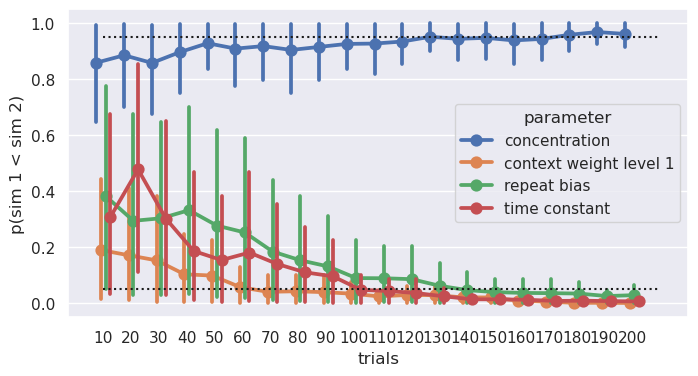

In [6]:
individual_fit_test_file = f"Results/Simulations/sim_8_9_bootstrap_test{file_suffix}.pkl"
OVERWRITE = False
blocks = range(1,20+1)

if((not os.path.isfile(individual_fit_test_file)) or OVERWRITE):
    pps, param_names =  bootstrap_pop_test([8,9],blocks)

    df_individual_fits = pd.DataFrame()
    for pp, param in enumerate(param_names):
        for bb, bn in enumerate(blocks):
            df_c = pd.DataFrame({"p_2_lt_3" : pps[pp, 0, bb, :],
                                 "p_2_gt_3" : pps[pp, 1, bb, :],
                                 "parameter" : param,
                                 "block" :  bn,
                                 "trials" :  bn * 10});
            df_individual_fits = pd.concat([df_individual_fits, df_c])
    df_individual_fits.to_pickle(individual_fit_test_file);
else:
    df_individual_fits = pd.read_pickle(individual_fit_test_file)

sns.set(rc = {'figure.figsize':(8, 4)})
sns.pointplot(data=df_individual_fits, x="trials", y="p_2_lt_3", hue="parameter", errorbar=("pi",75), dodge=0.5)
plt.plot([0,20],[0.05,0.05],'k:')
plt.plot([0,20],[0.95,0.95],'k:')
plt.ylabel("p(sim 1 < sim 2)");

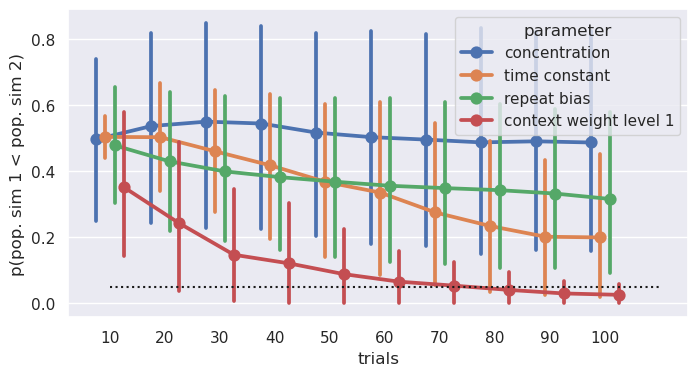

In [6]:
population_fit_test_file = f"Results/Simulations/sim_6_7_auroc_test{file_suffix}.pkl"
OVERWRITE = False
blocks = range(1,18+1);

if((not os.path.isfile(population_fit_test_file)) or OVERWRITE):
    aurocs, param_names =  test_posterior_marginals_separation([7,6],blocks)
    #                aurocs[ii, bb, r1,r2] = roc_auc_score(cs["simulation"], cs[pp])
    df_population_fits = pd.DataFrame()
    for pp, param in enumerate(param_names):
        for bb, bn in enumerate(blocks):
            df_c = pd.DataFrame({"auroc" : aurocs[pp, bb, :, :].flatten(),
                                 "aurocm" : 1-aurocs[pp, bb, :, :].flatten(),
                                 "parameter" : param,
                                 "block" : bn,
                                 "trials" : bn * 10});
            df_population_fits = pd.concat([df_population_fits, df_c])
    df_population_fits.to_pickle(population_fit_test_file);
else:
    df_population_fits = pd.read_pickle(population_fit_test_file)


sns.set(rc = {'figure.figsize':(8, 4)})
sns.pointplot(data=df_population_fits, x="trials", y="aurocm", hue="parameter", errorbar=("pi",75), dodge=0.5)
plt.plot([0,10],[0.05,0.05],'k:')
plt.ylabel("p(pop. sim 1 < pop. sim 2)");


In [8]:
def plot_params_over_blocks(sim,block=range(1,11)):
    if(isinstance(sim, pd.DataFrame)):
        a = sim;
    else:
        if(isinstance(sim,int)):
            sim = [sim]
        if(isinstance(block,int)):
            block = [block]



        a,_,_ = load_summary(sim,block)
        a.reset_index();

    xlabel = "trials"
    multiplier = 10
    a[xlabel]  = a["block"].astype(int) * multiplier
    
    g = sns.FacetGrid(a, row="parameter", height=1.5, aspect=10/(1.5), sharey=False);
    g.map_dataframe(sns.pointplot, x=xlabel, y=var_to_plot, errorbar=("pi",90), dodge=0.1, hue="simulation", palette=palette);
    g.map_dataframe(sns.pointplot, x=xlabel, y="true",  linestyles="--", markers="", hue="simulation", palette=palette); #
    g.add_legend()
    for ax in g.axes[:,0]:
        ax.set_ylabel(None);
    
    g.axes[-1,0].set_ylabel('estimate')
    return g;


In [9]:

def plot_params_per_sim(sim,block):
    if(isinstance(sim,int)):
        sim = [sim]
    assert isinstance(block,int) or len(block)==1, "only one block"
    a,_,_ = load_summary(sim,block)
    a.reset_index();

    dodge = 0.2 if len(sim) > 1 else False;

    g = sns.FacetGrid(a, col="parameter",  height=3, aspect=1, sharey=False);
    g.map_dataframe(sns.stripplot, x="simulation", hue="simulation", y=var_to_plot, dodge=False, alpha=0.75, palette=palette,size=2); #
    g.map_dataframe(sns.pointplot, x="simulation", y="true", dodge=dodge, linestyles="none", markers="d", markersize=6, palette=palette, errorbar=None,linewidth=0.5,alpha=1,  hue="simulation");
    g.map_dataframe(sns.pointplot, x="simulation", y=var_to_plot,
                    dodge=False, linestyles="none", markers="o",
                    markersize=4, palette=palette, errorbar=("pi",90),
                    linewidth=1, alpha=1,  hue="simulation");
    return g;


/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


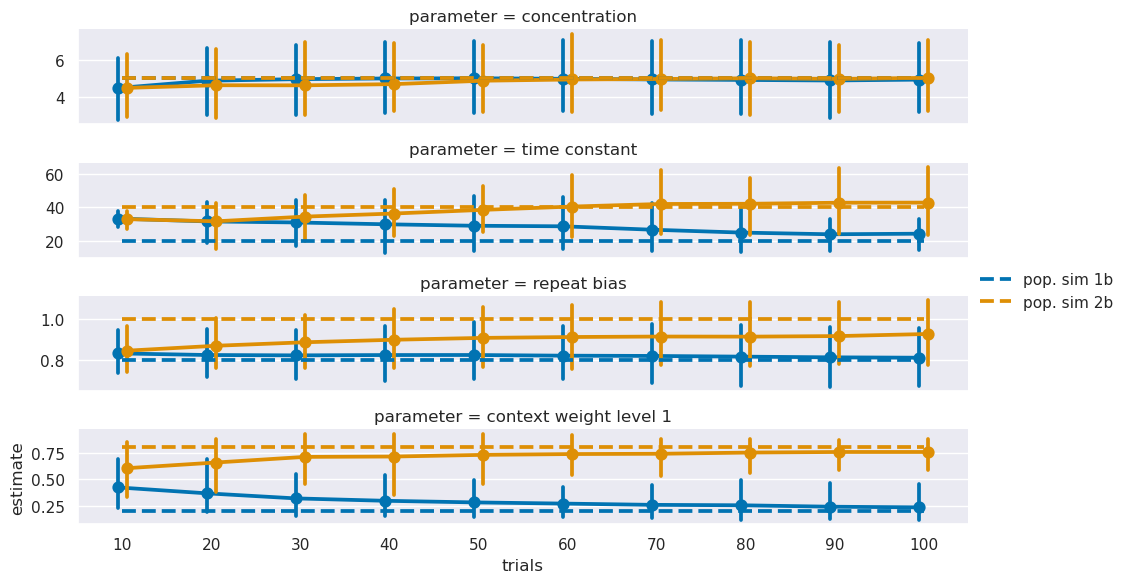

In [9]:
plot_params_over_blocks([6,7],range(1,10+1));

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


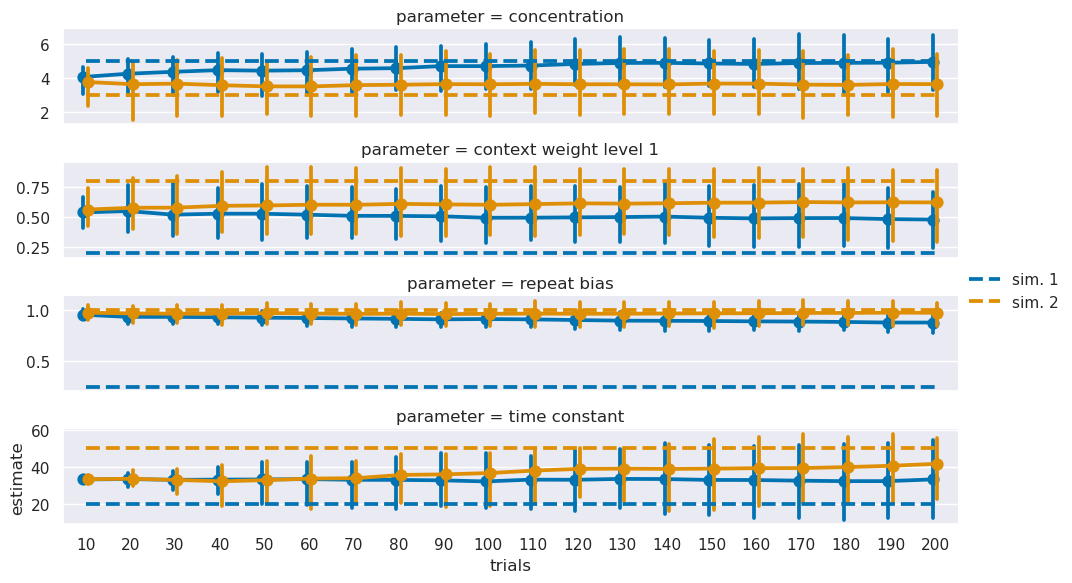

In [10]:
plot_params_over_blocks([8,9],range(1,20+1));

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


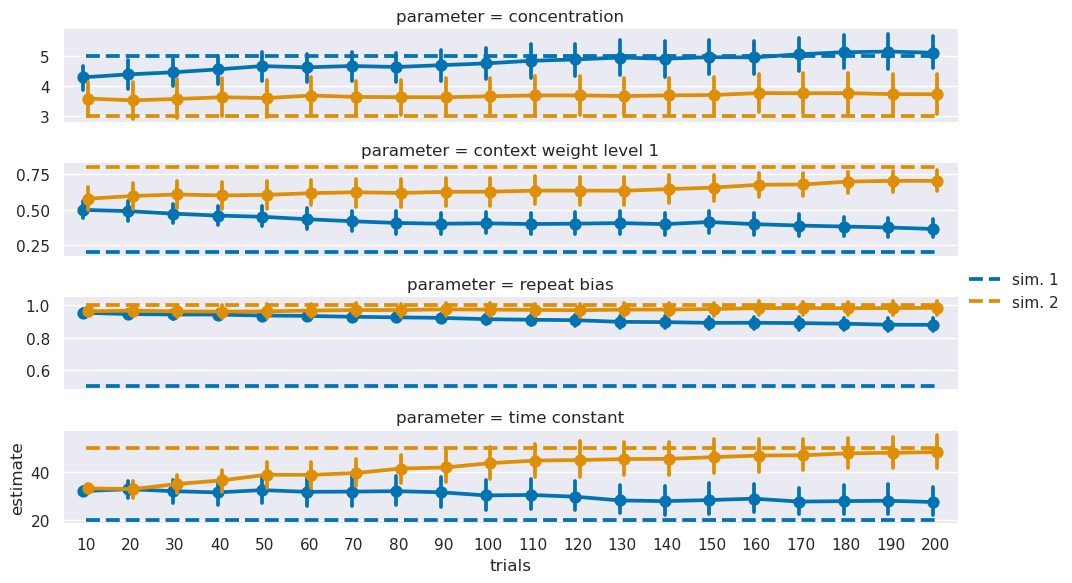

In [11]:
individual_fit_pop_sample_file = f"Results/Simulations/sim_8_9_bootstrap_pops{file_suffix}.pkl"
OVERWRITE = False
blocks = range(1,20+1)

if((not os.path.isfile(individual_fit_pop_sample_file)) or OVERWRITE):
    df_individual_fits_pops =  bootstrap_pop_means([8,9],blocks)

    df_individual_fits_pops.to_pickle(individual_fit_pop_sample_file);
else:
    df_individual_fits_pops = pd.read_pickle(individual_fit_pop_sample_file)
plot_params_over_blocks(df_individual_fits_pops);

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


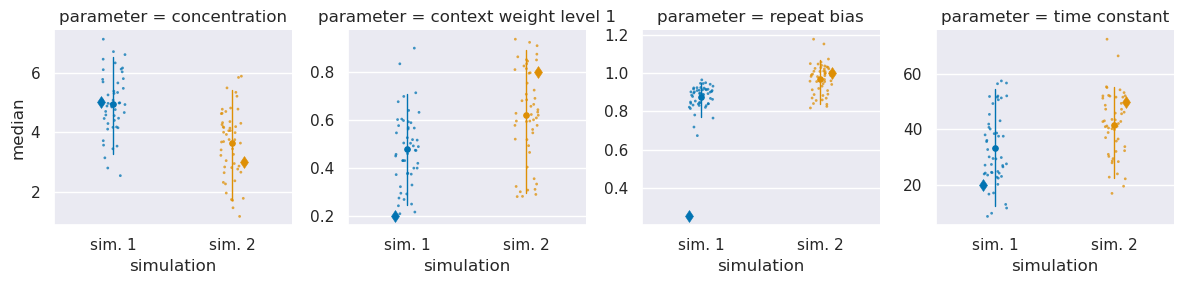

In [12]:
sim = [8,9];
block = 20;
plot_params_per_sim(sim, block)

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


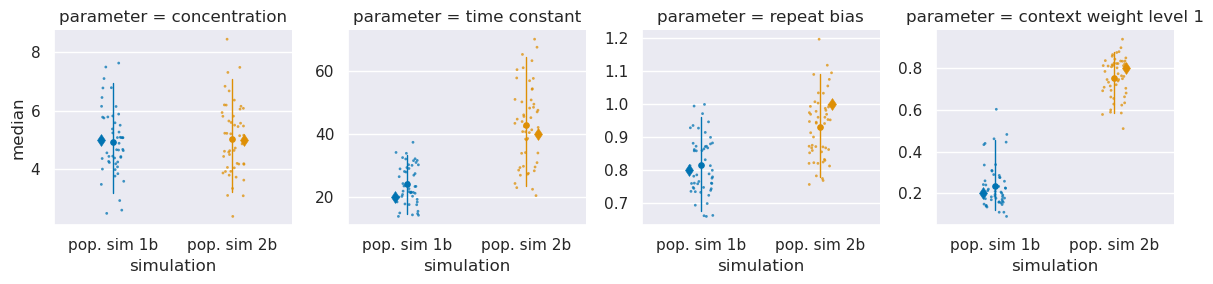

In [13]:
sim = [6,7];
block = 10;
plot_params_per_sim(sim, block)

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


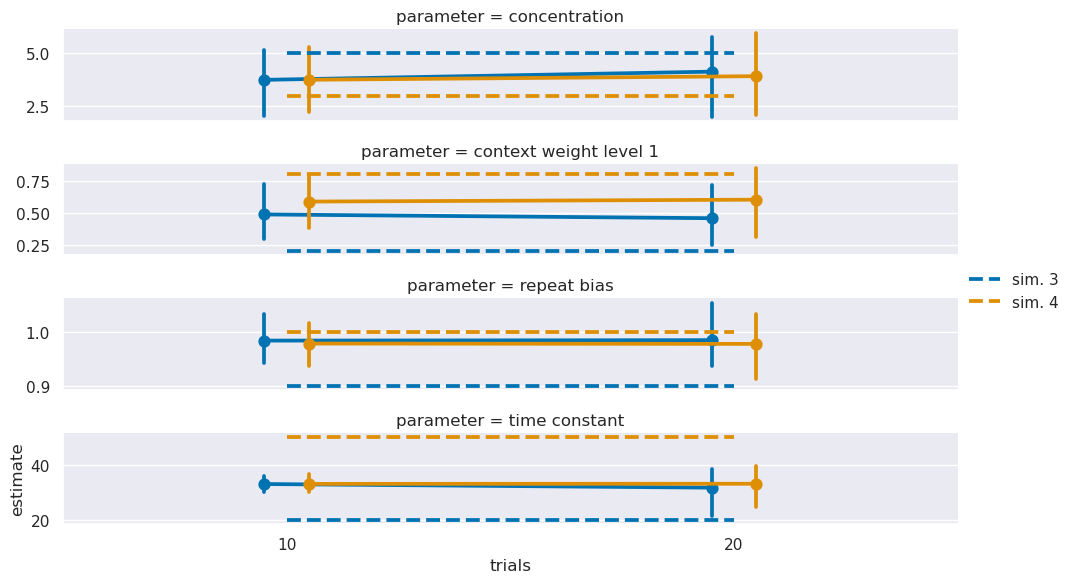

In [14]:
plot_params_over_blocks([12,13],range(1,2+1));